<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Konwolucyjna sieć neuronowa - Pies czy kot?

### Czyszczenie katalogu roboczego

In [0]:
# czyscimy katalog roboczy
%%bash
rm -rf /content/*

### Zaimportowanie wymaganych bibliotek

In [0]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# zignoruje pewne spostrzezenia, tak aby kod byl bardziej czytelny
import warnings
warnings.filterwarnings('ignore')

### Pobieranie danych
Dane pobierzemy z bucketu S3 z chmury Amazona.

Nazwa busketu to: `ml-repository-krakers`

In [5]:
%%bash
pwd
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip
ls

/content
cats_and_dogs.zip


### Wypakowanie danych

In [6]:
%%bash
unzip cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle__original_data/train

unzip -q /content/test1.zip
ls

Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: test1.zip               
cats_and_dogs.zip
kaggle_original_data
test1
test1.zip


### Zdefiniowanie użytecznych funkcji

In [0]:
def make_accuracy_plot(history):
  """
  Funkcja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym i walidacyjnym.
  """
  acc, val_acc = history.history['acc'], history.history['val_acc']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(10, 8))
  plt.plot(epochs, acc, label='Dokładność trenowania', marker='o')
  plt.plot(epochs, val_acc, label='Dokładność walidacji', marker='o')
  plt.legend()
  plt.title('Dokładność trenowania i walidacji')
  plt.xlabel('Epoki')
  plt.ylabel('Dokładność')
  plt.show()

def make_loss_plot(history):
  """
  Funkcja zwraca wykres starty (loss) modelu na zbiorze treningowym i walidacyjnym.
  """
  loss, val_loss = history.history['loss'], history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10, 8))
  plt.plot(epochs, loss, label='Strata trenowania', marker='o')
  plt.plot(epochs, val_loss, label='Strata walidacji', marker='o')
  plt.legend()
  plt.title('Strata trenowania i walidacji')
  plt.xlabel('Epoki')
  plt.ylabel('Strata')
  plt.show()

def display_augmented_images(directory, index):
  """
  Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
  augmentacji danych.
  """
  fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
  img_path = fnames[index]
  img = image.load_img(img_path, target_size=(150, 150))

  x = image.img_to_array(img)
  x = x.reshape((1, ) + x.shape)

  i = 1
  plt.figure(figsize=(20, 14))
  for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
      break

### Przygotowanie katalogów
Nasze dane znajdować się będą w katalogu:

`/content/cats_and_dogs`

Podzielimy ten katalog na trzy podkatalogi:

*   **train** (2000 próbek, po 1000 na klasę)
*   **valid** (1000 próbek, po 500 na klasę)
*   **test** (1000 próbek, po 500 na klasę)

In [0]:
# ścieżka do oryginalnego zbioru
original_dataset_dir = '/content/kaggle_original_data'
# katalog, w których umieścimy nasze dane
base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir):
  os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(base_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(base_dir, 'test')      # katalog zbioru testowego

for dictionary in (train_dir, valid_dir, test_dir):
  if not os.path.exists(dictionary):
    os.mkdir(dictionary)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]

for directory in dirs:
  if not os.path.exists(directory):
    os.mkdir(directory)

In [0]:
# rozdzielamy zdjęcia kotów
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(valid_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

# rozdzielamy zdjęcia psów
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(valid_dogs_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

### Sprawdzenie poprawności podziału

In [10]:
print('Liczba kotów - zbiór treningowy', len(os.listdir(train_cats_dir)))
print('Liczba kotów - zbiór walidacyjny', len(os.listdir(valid_cats_dir)))
print('Liczba kotów - zbiór testowy', len(os.listdir(test_cats_dir)))

print('Liczba psów - zbiór treningowy', len(os.listdir(train_dogs_dir)))
print('Liczba psów - zbiór walidacyjny', len(os.listdir(valid_dogs_dir)))
print('Liczba psów - zbiór testowy', len(os.listdir(test_dogs_dir)))

Liczba kotów - zbiór treningowy 1000
Liczba kotów - zbiór walidacyjny 500
Liczba kotów - zbiór testowy 500
Liczba psów - zbiór treningowy 1000
Liczba psów - zbiór walidacyjny 500
Liczba psów - zbiór testowy 500


### Przyjrzenie się przykładowym obrazom - koty

Using TensorFlow backend.


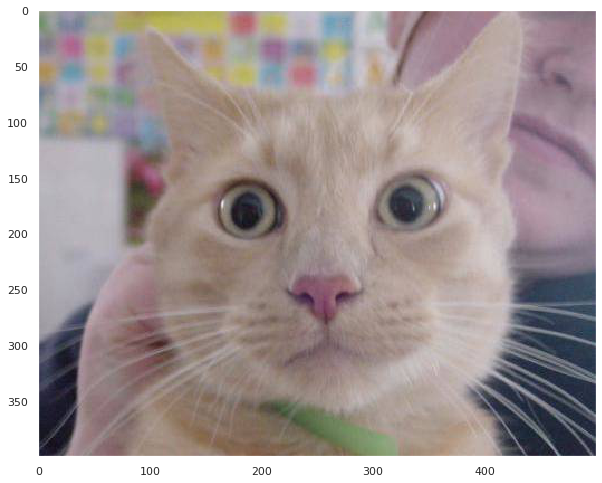

In [11]:
#@title Wybierz indeks przykładowego zdjęcia kota:
from keras.preprocessing import image

index = 444 #@param {type: 'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/cats/cat.' + str(index) + '.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)

### Przyjrzenie się przykładowym obrazom - psy

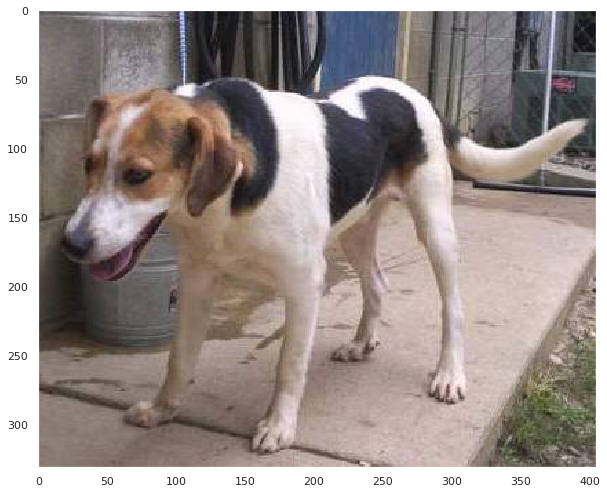

In [12]:
#@title Wybierz indeks przykładowego zdjęcia psa:
from keras.preprocessing import image

index = 665 #@param {type: 'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/dogs/dog.' + str(index) + '.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)

### Budowa modelu

In [13]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)  

### Kompilacja modelu

In [14]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Przetworzenie danych do modelu

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# przeskalowujemy wszystkie obrazy o współczynniku 1/255
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Sprawdzenie poprawności kształtu danych treningowych

In [16]:
for data_batch, labels_batch in train_generator:
  print('Kształt danych wsadowych:', data_batch.shape)
  print('Kształt etykiet danych wsadowych:', labels_batch.shape)
  break

Kształt danych wsadowych: (20, 150, 150, 3)
Kształt etykiet danych wsadowych: (20,)


### Dopasowanie modelu
Wytrenowany model zapisujemy do pliku `cats_and_dogs_small_1.h5`

Przed tym krokiem najlepiej przełączyć się na GPU!! Czas trenowania dla poszczególnej epoki na CPU to 120s (2 min), na GPU - 7s.

In [17]:
import time

tic = time.time()
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=valid_generator,
                              validation_steps=50)

toc = time.time()
print('Czas przetwarzania: {}'.format(toc - tic))
model.save('cats_and_dogs_small_1.h5')




Epoch 1/30





100/100 [==============================] - 21s 212ms/step - loss: 0.6893 - acc: 0.5400 - val_loss: 0.6778 - val_acc: 0.5150
Epoch 2/30
100/100 [==============================] - 7s 73ms/step - loss: 0.6538 - acc: 0.6190 - val_loss: 0.6400 - val_acc: 0.6250
Epoch 3/30
100/100 [==============================] - 7s 73ms/step - loss: 0.6041 - acc: 0.6665 - val_loss: 0.6060 - val_acc: 0.6750
Epoch 4/30
100/100 [==============================] - 7s 73ms/step - loss: 0.5617 - acc: 0.7160 - val_loss: 0.6170 - val_acc: 0.6550
Epoch 5/30
100/100 [==============================] - 7s 73ms/step - loss: 0.5271 - acc: 0.7415 - val_loss: 0.5869 - val_acc: 0.7000
Epoch 6/30
100/100 [==============================] - 7s 73ms/step - loss: 0.5061 - acc: 0.7570 - val_loss: 0.5590 - val_acc: 0.7190
Epoch 7/30
100/100 [==============================] - 7s 73ms/step - loss: 0.4648 - acc: 0.7790 - val_loss: 0.5317 - val_acc: 0.7440
Epoch 8/30
100/100 [==============================] - 7s 73

### Wykres dokładności trenowania i walidacji

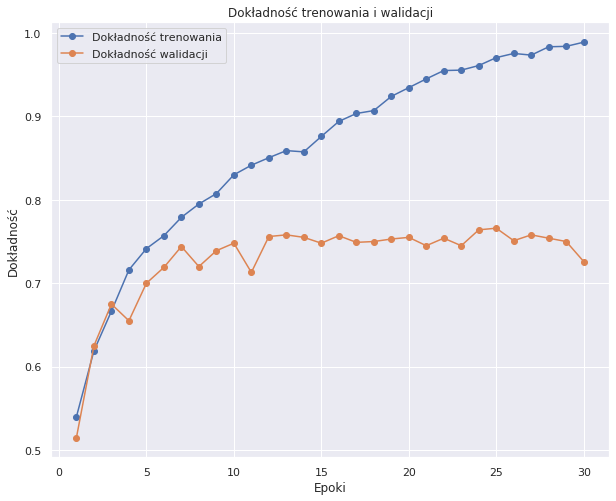

In [18]:
make_accuracy_plot(history)

### Wykres straty trenowania i walidacji

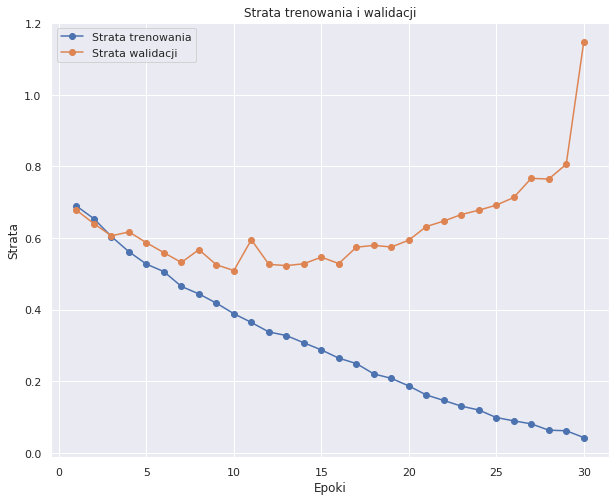

In [24]:
make_loss_plot(history)

### Augmentacja danych
Technika przekształcająca dane wejściowe poprzez takie operacje jak przycinanie, obrót czy powiększanie w celu wygenerowania nowych danych wejściowych (obrazków).

In [0]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

### Wyświetlenie kilku przykładów augmentacji - koty

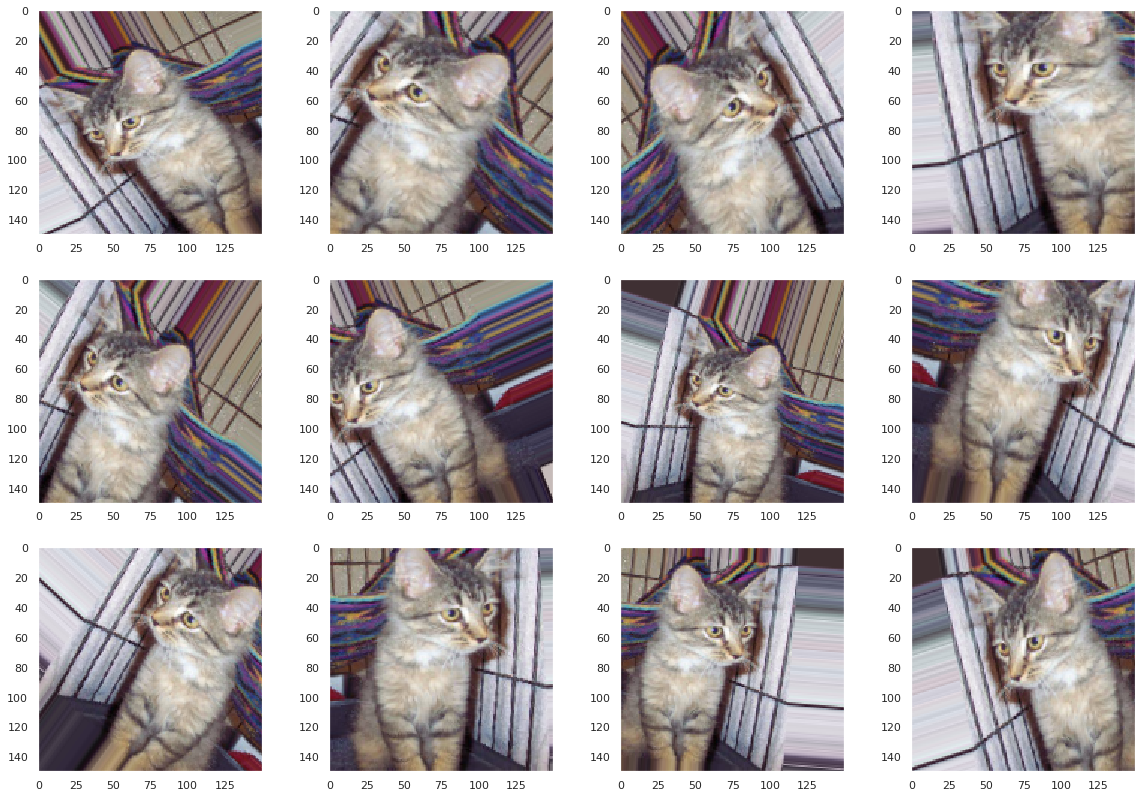

In [26]:
#@title Wybierz index obrazka w celu jego eksploracji
from keras.preprocessing import image

index = 323 #@param {type: 'slider', min:0, max:999}
display_augmented_images(train_cats_dir, index)

### Wyświetlenie kilku przykładów augmentacji - psy

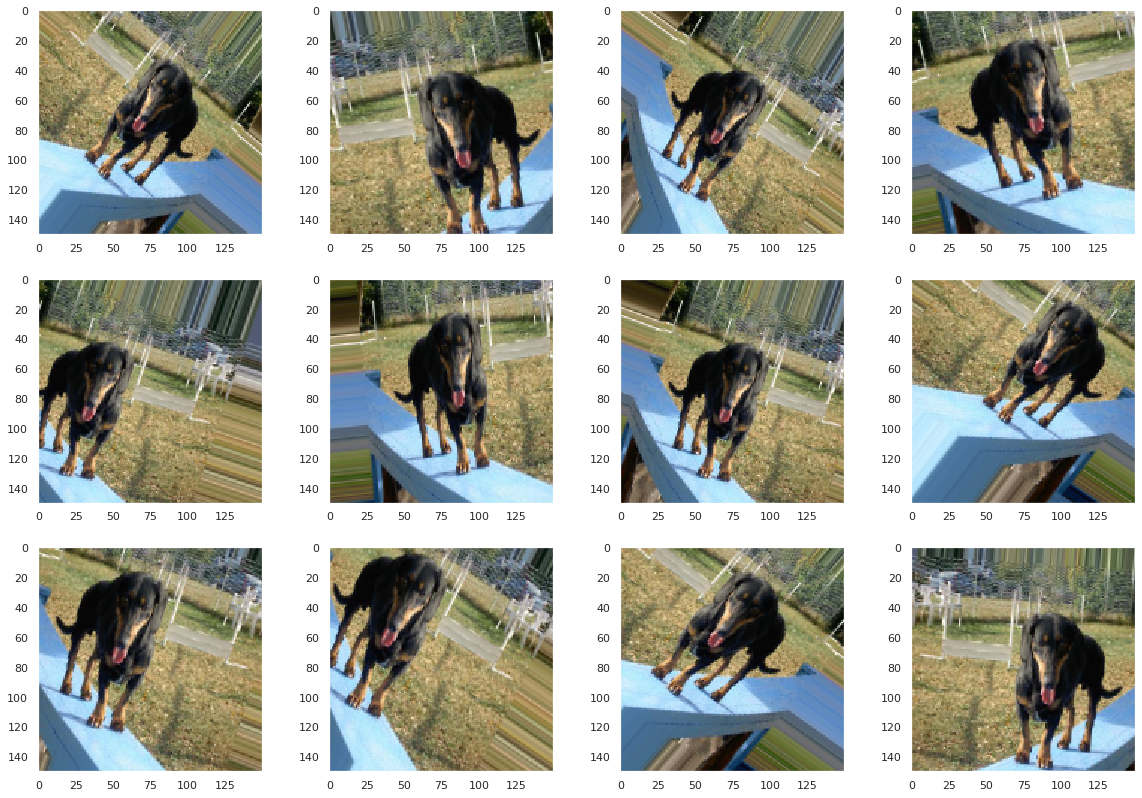

In [32]:
index = 333 #@param {type: 'slider', min:0, max:999}
display_augmented_images(train_dogs_dir, index)

### Trenowanie CNN z wykorzystaniem obrazów wygenerwanych za pomocą augmentacji danych

In [33]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
____

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# nie modyfikujemy danych walidacyjnych!!!
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Trenowanie modelu

In [35]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 269ms/step - loss: 0.7151 - acc: 0.5066 - val_loss: 0.6867 - val_acc: 0.5882
Epoch 2/100
100/100 [==============================] - 24s 244ms/step - loss: 0.7113 - acc: 0.5709 - val_loss: 0.6735 - val_acc: 0.5496
Epoch 3/100
100/100 [==============================] - 24s 243ms/step - loss: 0.6984 - acc: 0.6094 - val_loss: 0.6367 - val_acc: 0.6421
Epoch 4/100
100/100 [==============================] - 24s 242ms/step - loss: 0.6511 - acc: 0.6197 - val_loss: 0.5997 - val_acc: 0.6804
Epoch 5/100
100/100 [==============================] - 23s 232ms/step - loss: 0.6302 - acc: 0.6578 - val_loss: 0.5591 - val_acc: 0.7113
Epoch 6/100
100/100 [==============================] - 26s 260ms/step - loss: 0.6155 - acc: 0.6691 - val_loss: 0.5733 - val_acc: 0.7010
Epoch 7/100
100/100 [==============================] - 24s 243ms/step - loss: 0.6161 - acc: 0.6778 - val_loss: 0.5850 - val_acc: 0.6923
Epoch 8/100
100/100 [===========================

### Zapisanie modelu do pliku

In [0]:
model.save('cats_and_dogs_small_2.h5')

### Wykres dokładności trenowania i walidacji

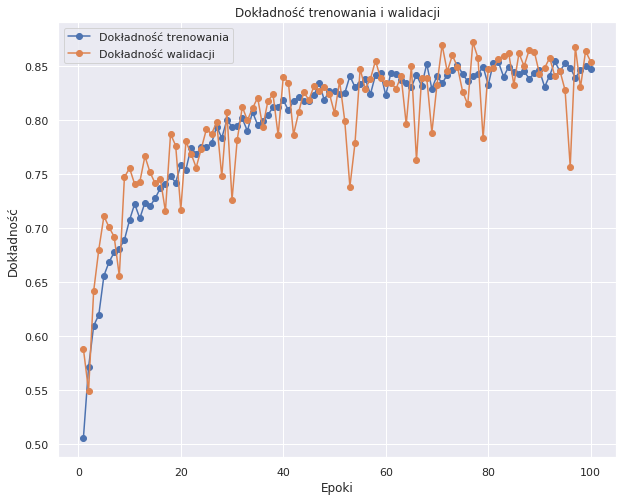

In [37]:
make_accuracy_plot(history)

### Wykres straty trenowania i walidacji

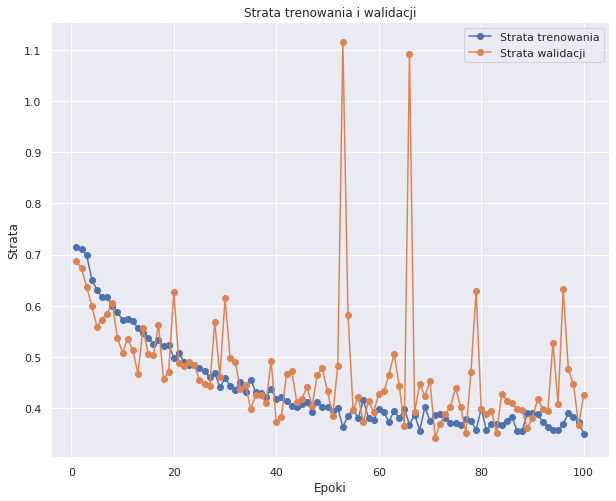

In [38]:
make_loss_plot(history)

### Transfer Learning - korzystanie z uprzednio przetrenowanego modelu

In [39]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,  # czy dołączyc górną część sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

### Ekstrakcja cech z augmentacją danych

In [40]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Trenowanie modelu od początku do końca przy zamrożonej bazie konwolucyjnej

In [41]:
print('Liczba wag poddanych trenowaniu przed zamrożeniem bazy:', len(model.trainable_weights))
conv_base.trainable = False
print('Liczba wag poddanych trenowaniu po zamrożeniu bazy:', len(model.trainable_weights))

Liczba wag poddanych trenowaniu przed zamrożeniem bazy: 30
Liczba wag poddanych trenowaniu po zamrożeniu bazy: 4


In [42]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# dane walidacyjne / testowe nie mogą być modyfikowane!!!
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [44]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=valid_generator,
                              validation_steps=50,
                              verbose=2)

Epoch 1/50
 - 17s - loss: 0.6085 - acc: 0.6720 - val_loss: 0.4622 - val_acc: 0.8300
Epoch 2/50
 - 16s - loss: 0.4916 - acc: 0.7850 - val_loss: 0.3737 - val_acc: 0.8570
Epoch 3/50
 - 16s - loss: 0.4325 - acc: 0.8130 - val_loss: 0.3303 - val_acc: 0.8690
Epoch 4/50
 - 16s - loss: 0.4075 - acc: 0.8225 - val_loss: 0.3184 - val_acc: 0.8730
Epoch 5/50
 - 16s - loss: 0.3908 - acc: 0.8230 - val_loss: 0.3101 - val_acc: 0.8690
Epoch 6/50
 - 16s - loss: 0.3655 - acc: 0.8490 - val_loss: 0.2806 - val_acc: 0.8850
Epoch 7/50
 - 15s - loss: 0.3581 - acc: 0.8505 - val_loss: 0.2735 - val_acc: 0.8970
Epoch 8/50
 - 16s - loss: 0.3549 - acc: 0.8390 - val_loss: 0.2664 - val_acc: 0.8960
Epoch 9/50
 - 16s - loss: 0.3451 - acc: 0.8420 - val_loss: 0.2700 - val_acc: 0.8890
Epoch 10/50
 - 16s - loss: 0.3371 - acc: 0.8500 - val_loss: 0.2616 - val_acc: 0.8940
Epoch 11/50
 - 16s - loss: 0.3280 - acc: 0.8555 - val_loss: 0.2596 - val_acc: 0.8920
Epoch 12/50
 - 16s - loss: 0.3299 - acc: 0.8615 - val_loss: 0.2564 - val_a

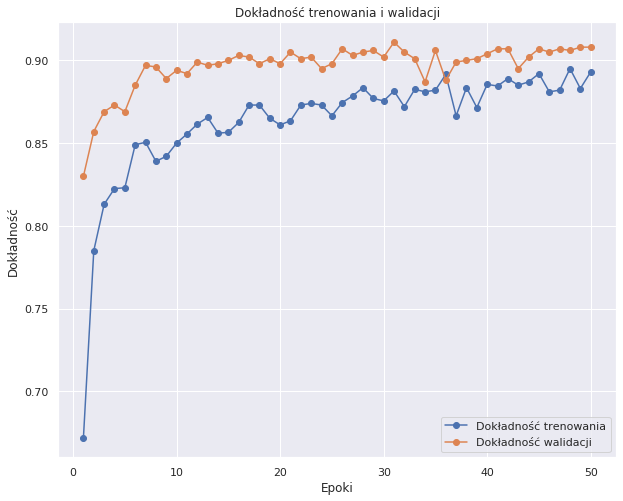

In [45]:
make_accuracy_plot(history)

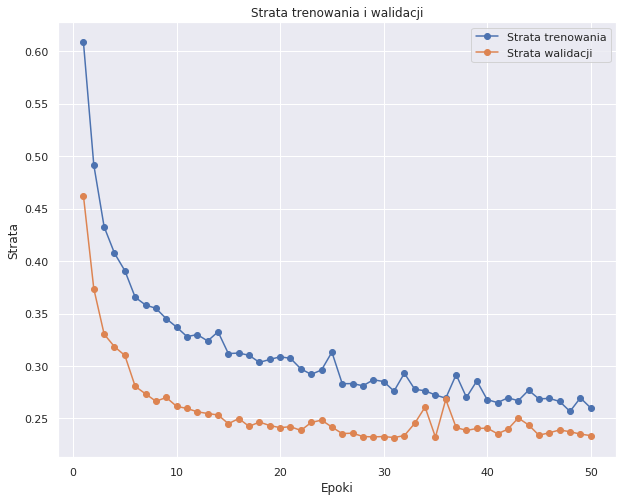

In [46]:
make_loss_plot(history)

### Wizualizacja efektów uczenia sieci konwolucyjnych
Polega na wyświetleniu map cech, które generują się przez różne warstwy konwolucyjne.

In [48]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [50]:
#@title Wybierz indeks obrazka:
index = 1559 #@param {type: 'slider', min:0, max:1999}
img_path = '/content/cats_and_dogs/test/cats/cat.' + str(index) + '.jpg'

from keras.preprocessing import image
import numpy as np

# przetwarzamy obraz tak, aby uzyskał formę czterowymiarowego tensora
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


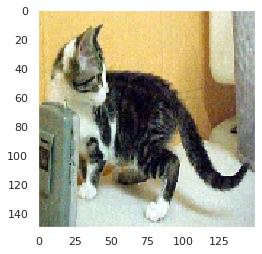

In [51]:
plt.imshow(img_tensor[0])
plt.grid(False)

In [54]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


### Wyświetlenie map cech

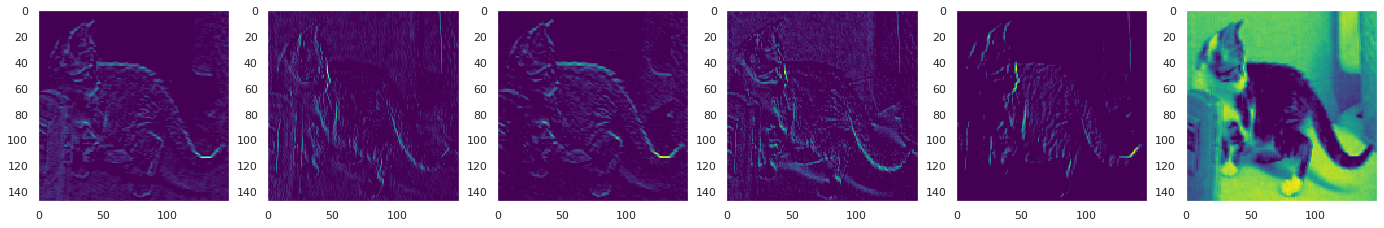

In [57]:
plt.figure(figsize=(24, 24))

for i in range(1, 7):
  plt.subplot(1, 6, i)
  plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
  plt.grid(False)

### Wizualizacja wszystkich kanałów dla pośredniej warstwy aktywacji

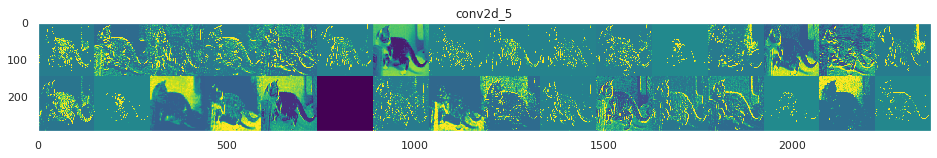

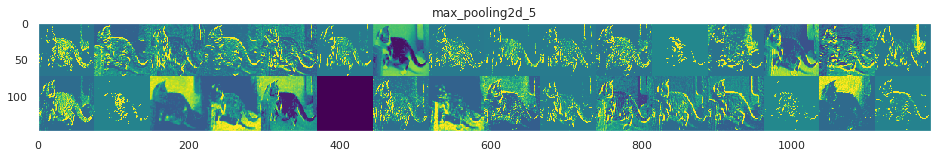

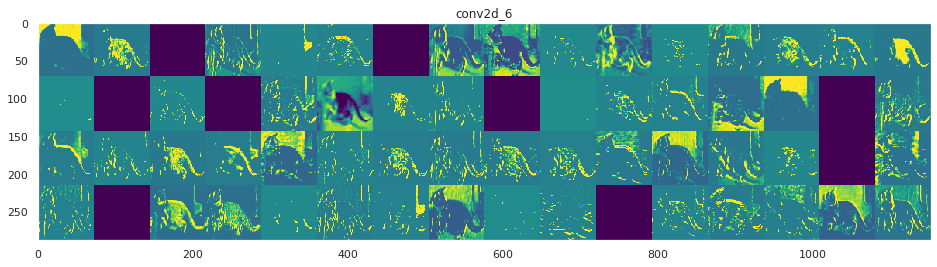

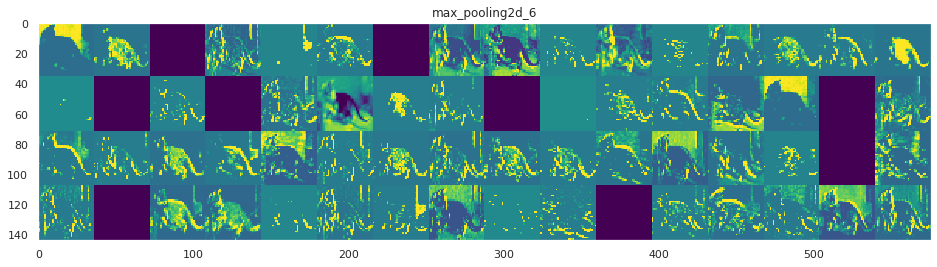

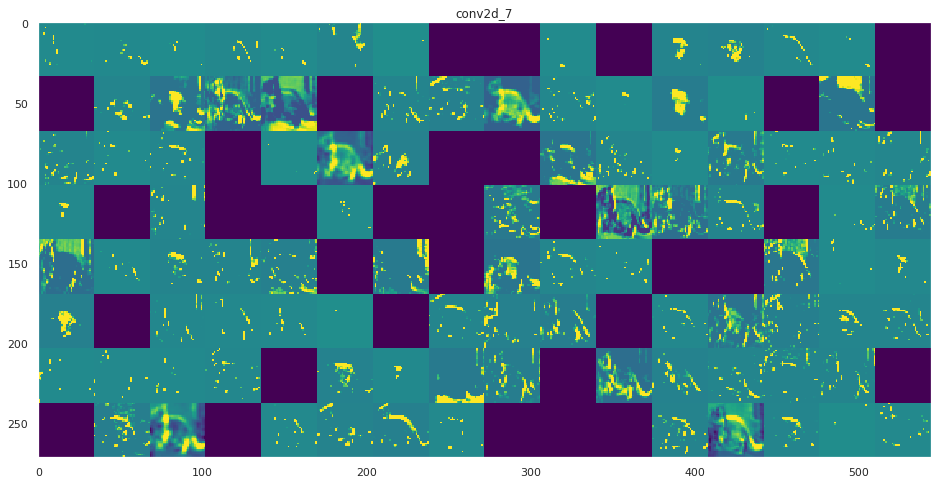

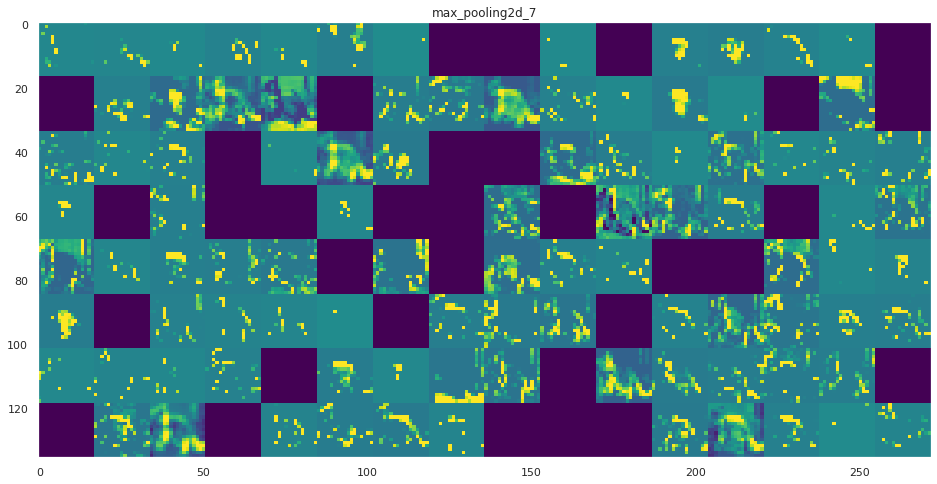

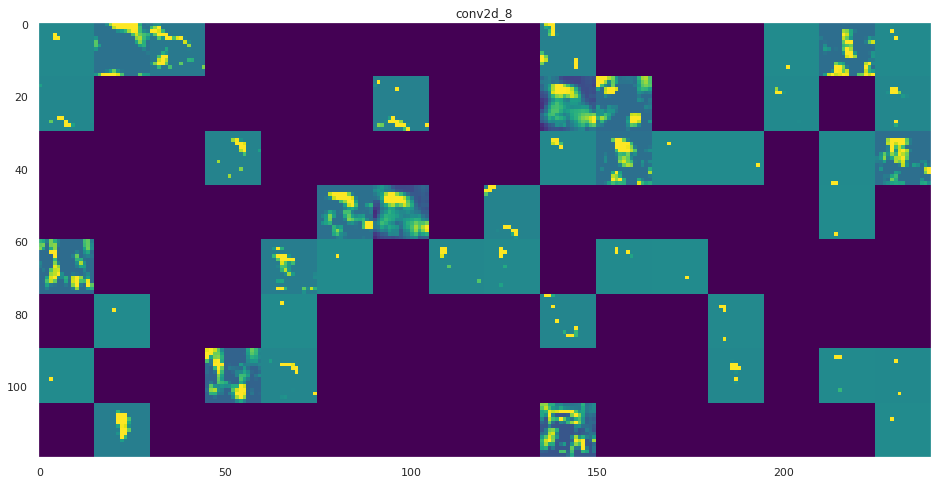

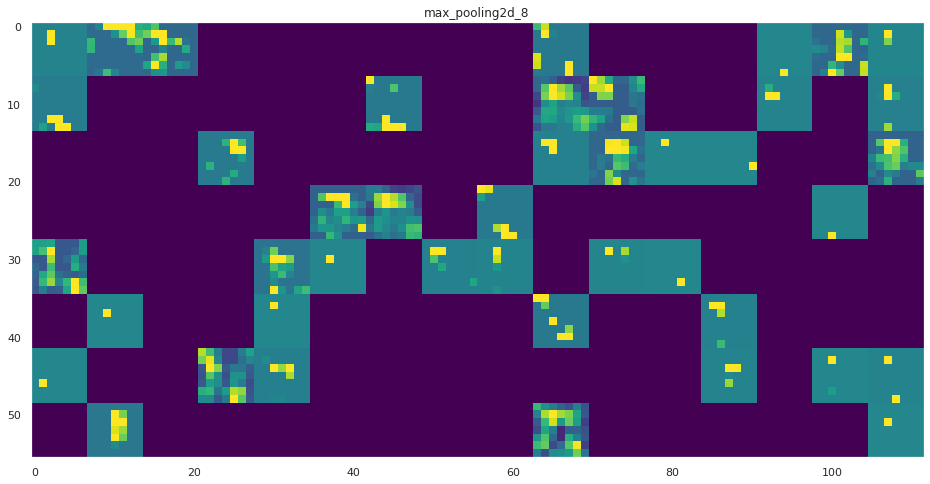

In [63]:
layer_names = [layer.name for layer in model.layers[:8]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  n_cols = n_features // images_per_row

  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col + 1) * size, row * size: (row+ + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Wizualizacja filtrów konwolucyjnych sieci neuronowych
Filtr konwolucyjny to inaczej graficzny wzorzec, na który reaguje podany filtr.

In [0]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

for i in range(40):
  loss_value, grads_value = iterate([input_img_data])

  input_img_data += grads_value * step

def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])

  grads = K.gradients(loss, model.input)[0]

  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

  iterate = K.function([model.input], [loss, grads])

  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

  step = 1
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

  img = input_img_data[0]
  return deprocess_image(img)

In [75]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Wyświetlenie kilku przykładowych filtrów 

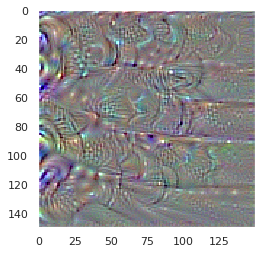

In [88]:
#@title Wybierz warstwę:
layer = 'block5_conv2' #@param ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']
plt.imshow(generate_pattern(layer, 1))
plt.grid(False)

### Wizualizacje map ciepła aktywacji klas
Ta metoda pozwala nam stwierdzić na podstawie której części obrazu model podjął taką a nie inną decyzję. Przydatna do błędnie sklasyfikowanych obrazów.

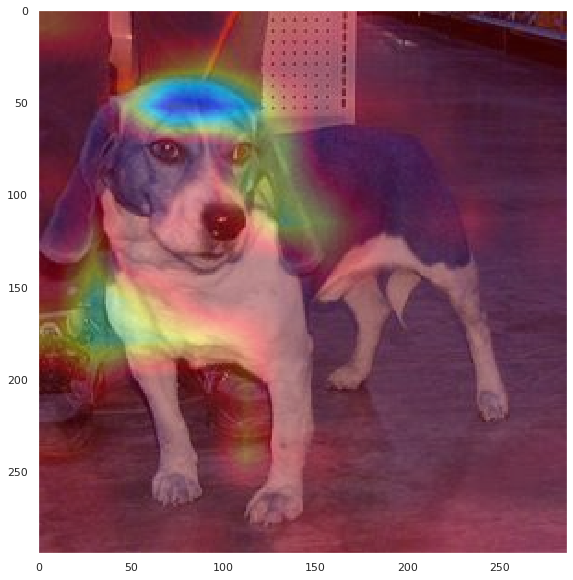

In [109]:
#@title Wybierz numer indeksu zdjęcia
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

pets = 'dogs' #@param ['cats', 'dogs']
index = 1691 #@param {'type': 'slider', min: 1500, max: 1999}

model = VGG16(weights='imagenet')
img_path = '/content/cats_and_dogs/test/' + pets + '/' + pets[:3] + '.' + str(index) + '.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.imshow(superimposed_img, cmap='viridis')
plt.grid(False)
plt.show()